In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import time

## Params

In [2]:
############# Parameters ###############
params = {'input':2,
          'output':1,
          'N':32,
          'lr':0.0003,
          'rho':1e-5,
          'seed':1836702,
          'n_folds':5,
          'epoch':300,
          'method': "BFGS"}

## DataLoader

In [3]:
def load_dataset():
    data = pd.read_excel('dataPoints.xlsx')
    X, y = data[['x1','x2']], data[['y']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
 
    return X_train, y_train, X_test, y_test
  
X_train, y_train, X_test, y_test = load_dataset()

## Models

In [4]:
class MLP(object):
    def __init__(self, neurons_hidden, method, regularization = 10e-4):
        self.input = None
        self.output = None
        self.neurons_hidden = neurons_hidden
        self.regularization = regularization
        self.method = method
        self.input_weights = None 
        self.output_weights = None 
        self.bias = None 
        self.losses = []
    
    def activation(self, x):
        return np.tanh(x)

    def predict(self, X):
        # hidden layer 
        hidden_layer = X.dot(self.input_weights) + self.bias
        hidden_layer = self.activation(hidden_layer)
        # output layer (network output)
        output_layer = hidden_layer.dot(self.output_weights)
        return output_layer

    def _init_weights(self, X):
        input_weights = random.rand(X.shape[1], self.neurons_hidden)
        output_weights = random.rand(self.neurons_hidden, 1)
        bias = random.uniform(0, 1, (1, self.neurons_hidden))/2
        return input_weights, output_weights, bias
    
    # Optimization 
    def fit(self, X, y):
        self.input_weights, self.output_weights, self.bias = self._init_weights(X)
        self.input, self.output = X, y
        # initial error
        result = self.activation((self.input.dot(self.input_weights) + self.bias)).dot(self.output_weights)
        # wrapping arguments
        x0 = np.concatenate([self.input_weights, self.output_weights.T, self.bias]).reshape(-1,)
        # optimization

        res = minimize(self.cost, x0, method = self.method)
        
        # updating weights and bias
        self.input_weights = res.x.reshape(4,-1)[:-2,:]
        self.output_weights = res.x.reshape(4,-1)[-2,:].reshape(-1,1)
        self.bias = res.x.reshape(4,-1)[-1,:]
        return res
    
    def cost(self, argus):
        # unwrapping arguments
        self.input_weights = argus.reshape(4,-1)[:-2,:]
        self.output_weights = argus.reshape(4,-1)[-2,:].reshape(-1,1)
        self.bias = argus.reshape(4,-1)[-1,:]
        # predict y values
        y_pred = self.predict(self.input)
        # error
        output_cost = np.mean((self.output - y_pred)**2) / 2
        # regularization error
        m = self.output.shape[1]
        L2_regularization_cost = self.regularization / (m * 2) * \
                                                (np.sum(np.square(self.input_weights)) + np.sum(np.square(self.output_weights)))
        # total error
        total_cost = output_cost + L2_regularization_cost
        return total_cost

    def _func(self, x1, x2):
        y = []
        for i in x1:
            y_sub = []
            for j in x2:
                x = np.hstack([i, j])
                y_sub.append(self.activation((x.dot(self.input_weights) + self.bias)).dot(self.output_weights))
            y.append(y_sub)
        y = np.array(y)
        return y.transpose(2,0,1).reshape(-1,y.shape[1])
    
    def plotting(self, title = "Plotting of the function"):
        #create the object
        fig = plt.figure(figsize=(15,10))
        ax = plt.axes(projection='3d')
        #create the grid
        x1 = np.linspace(-2, 2, 100).reshape(-1,1) 
        x2 = np.linspace(-1, 1, 100).reshape(-1,1) 
        X1, X2 = np.meshgrid(x1, x2) #create the grid for the plot
        Y = self._func(x1, x2) #evaluate the function (note that X1, X2, Z are matrix)
        ax.plot_surface(X1, X2, Y, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('y')
        ax.set_title(title)
        plt.show()
        
        

# Prediction

In [5]:
X_train, y_train, X_test, y_test = load_dataset()

X, y = X_train.values, y_train.values
kfold = KFold(params['n_folds'], random_state = 42, shuffle = True)
train_losses = []
val_losses = []
models = []

print("\nHyperparameters --------------------------------------------------")
print("Number of neurons N: ", params["N"])
print("sigma: ", 1)
print("rho: ", params["rho"])
print("Optimization method: ", params["method"])

print("\nOptimization -----------------------------------------------------")

start = time.time()
for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(X)):
    random.seed(params['seed']+k_fold)
    print("----Fold no: {}-------".format(k_fold+1))
    tr_x, tr_y = X[tr_inds], y[tr_inds]
    val_x, val_y = X[val_inds], y[val_inds]

    model = MLP(params['N'], params["method"], params['rho'])
    res = model.fit(tr_x, tr_y)

    preds = model.predict(val_x)
    models.append(model)

    train_losses.append(res.fun)    
    val_losses.append(mean_squared_error(preds, val_y))
    print("Val loss this fold: {}".format(mean_squared_error(preds, val_y)))
print("")
end = time.time()
print("time: {}".format((end-start) / params['n_folds']))

print("Train loss ave across all folds: {}".format(np.mean(train_losses)))
print("Val loss ave across all folds: {}".format(np.mean(val_losses)))


########### Prediction ############
print("\nPrediction ------------------------------------------------------")
for i in range(len(models)):
    if i == 0:
        pred = models[i].predict(X_test.values)
    else:
        pred += models[i].predict(X_test.values)
print("Final prediction error: {}".format(mean_squared_error(pred/params['n_folds'], y_test)))



Hyperparameters --------------------------------------------------
Number of neurons N:  32
sigma:  1
rho:  0.0001
Optimization method:  BFGS

Optimization -----------------------------------------------------
----Fold no: 1-------
Val loss this fold: 0.0014095328695929272
----Fold no: 2-------
Val loss this fold: 0.0024058056464789077
----Fold no: 3-------
Val loss this fold: 0.0009302897256868759
----Fold no: 4-------
Val loss this fold: 0.00247237070274408
----Fold no: 5-------
Val loss this fold: 0.002808970264553685
time: 52.549031829833986
Train loss ave across all folds: 0.006225157456973185
Val loss ave across all folds: 0.0020053938418112954

Prediction ------------------------------------------------------
Final prediction error: 0.00342393961060909


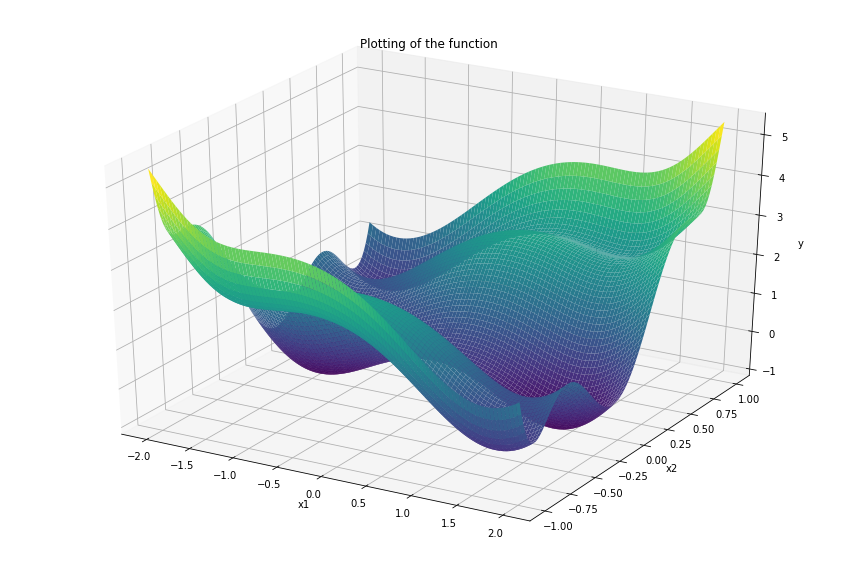

In [6]:
models[0].plotting()